# Using Machine Learning Tools Assignment 1

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of predicting bike rental demand. A data set has been provided containing records of bike rentals in Seoul, collected during 2017-18.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code and some require graphical results. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (with the correct results displayed) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code is written to run correctly on the original data file.

When creating graphical output, label is clearly, with appropriate titles, xlabels and ylabels, as appropriate.

Chapter 2 of the textbook is based on a similar workflow to this assignment, so you may look there for some further background and ideas. You can also use any other general resources on the internet that are relevant although do not use ones which directly relate to these questions with this dataset (which would normally only be found in someone else's assignment answers). If you take a large portion of code or text from the internet then you should reference where this was taken from, but we do not expect any references for small pieces of code. Taking, and adapting, small portions of code is expected and is common practice when solving real problems.

## The following code imports some of the essential libraries that you will need. You should not need to modify it, but you are expected to import other libraries as needed.

In [1]:
import pandas as pd
assert pd.__version__ >= "1.0"#added
import numpy as np
import os #added
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl #added
mpl.rc('axes', labelsize=14)#added
mpl.rc('xtick', labelsize=12)#added
mpl.rc('ytick', labelsize=12)#added
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin #added
#added
#python ≥3.5 
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >="0.20"

**STEP01:** 
Load the data set from the csv file (SeoulBikeData.csv) into a DataFrame, and summarise it with the pandas functions `describe()` and `info()`.

Download the data set from MyUni using the link provided on the assignment page. A paper that describes one related version of this dataset is: Sathishkumar V E, Jangwoo Park, and Yongyun Cho. 'Using data mining techniques for bike sharing demand prediction in metropolitan city.' Computer Communications, Vol.153, pp.353-366, March, 2020. Feel free to look at this if you want more information about the dataset.

The data is stored in a CSV (comma separated variable) file and contains the following information 

 - Date: year-month-day
 - Rented Bike Count: Count of bikes rented at each hour
 - Hour: Hour of the day
 - Temperature: Temperature in Celsius
 - Humidity: %
 - Windspeed: m/s
 - Visibility: 10m
 - Dew point temperature: Celsius
 - Solar radiation: MJ/m2
 - Rainfall: mm
 - Snowfall: cm
 - Seasons: Winter, Spring, Summer, Autumn
 - Holiday: Holiday/No holiday
 - Functional Day: NoFunc(Non Functional Hours), Fun(Functional hours)

**Load the data set from the csv file into a DataFrame, and summarise it with at least two appropriate pandas functions.**

_Points:_ 2

In [2]:
#load the data structure, taking a peak into top 5 rows
data = pd.read_csv("SeoulBikeData.csv")

display(data.head(5))
#each row represents an hour of each day. 
#there are 14 features visible below in the column headers

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0,0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0,0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0,0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0,0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0,0,Winter,No Holiday,Yes


In [3]:
data.info() #load the data description
# Note: There are 8760 instances in the dataset, which, according to Géron (48), is quite small by ML standards. I should note that there are null values present
# in Wind speed, Dew point temperature, and Rainfall, given their non-null counts are less than the total instances (8760). 
# These null values will need to be handled in short order. Some of the features with non-numerical object data types may also need to be dealt with at some stage
# and converted to integers or boolean values, but that remains to be seen.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature (C)            8760 non-null   float64
 4   Humidity (%)               8760 non-null   int64  
 5   Wind speed (m/s)           8759 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature (C)  8759 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8758 non-null   object 
 10  Snowfall (cm)              8760 non-null   object 
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [4]:
#load the categories for seasons
data["Seasons"].value_counts()
#there are 4 categories for the 4 seasons

Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: Seasons, dtype: int64

In [5]:
#load the summary of numerical attributes
data.describe()
# Note: Checking here for unusual values that may appear in the data. Temperature has a max value of 306 which is implausible. 
# The min and max values for Humidity cannot go below 0 for the min and over 100 for max. Wind speed has a max value of 2000, also implausible. 
# The min value for Visibility is -678. Visibility cannot go below 0.

,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2)
count,8760.000000,8760.000000,8760.000000,8760.000000,8759.000000,8760.000000,8759.000000,8760.000000
mean,704.602055,11.502740,12.914361,58.240183,1.953237,1436.442808,4.074369,0.569111
std,644.997468,6.922779,12.347109,20.584774,21.376612,608.827735,13.061011,0.868746
min,0.000000,0.000000,-17.800000,-26.000000,0.000000,-678.000000,-30.600000,0.000000
25%,191.000000,6.000000,3.500000,42.000000,0.900000,939.500000,-4.700000,0.000000
50%,504.500000,12.000000,13.700000,57.000000,1.500000,1697.500000,5.100000,0.010000
75%,1065.250000,18.000000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000
max,3556.000000,24.000000,306.000000,309.000000,2000.000000,2000.000000,27.200000,3.520000


In [6]:
step1_sol = data.shape 

**STEP02:** To get a feeling for the data it is a good idea to do some form of simple visualisation. Display a set of histograms for the features as they are right now, prior to any cleaning steps.

_Points:_ 0

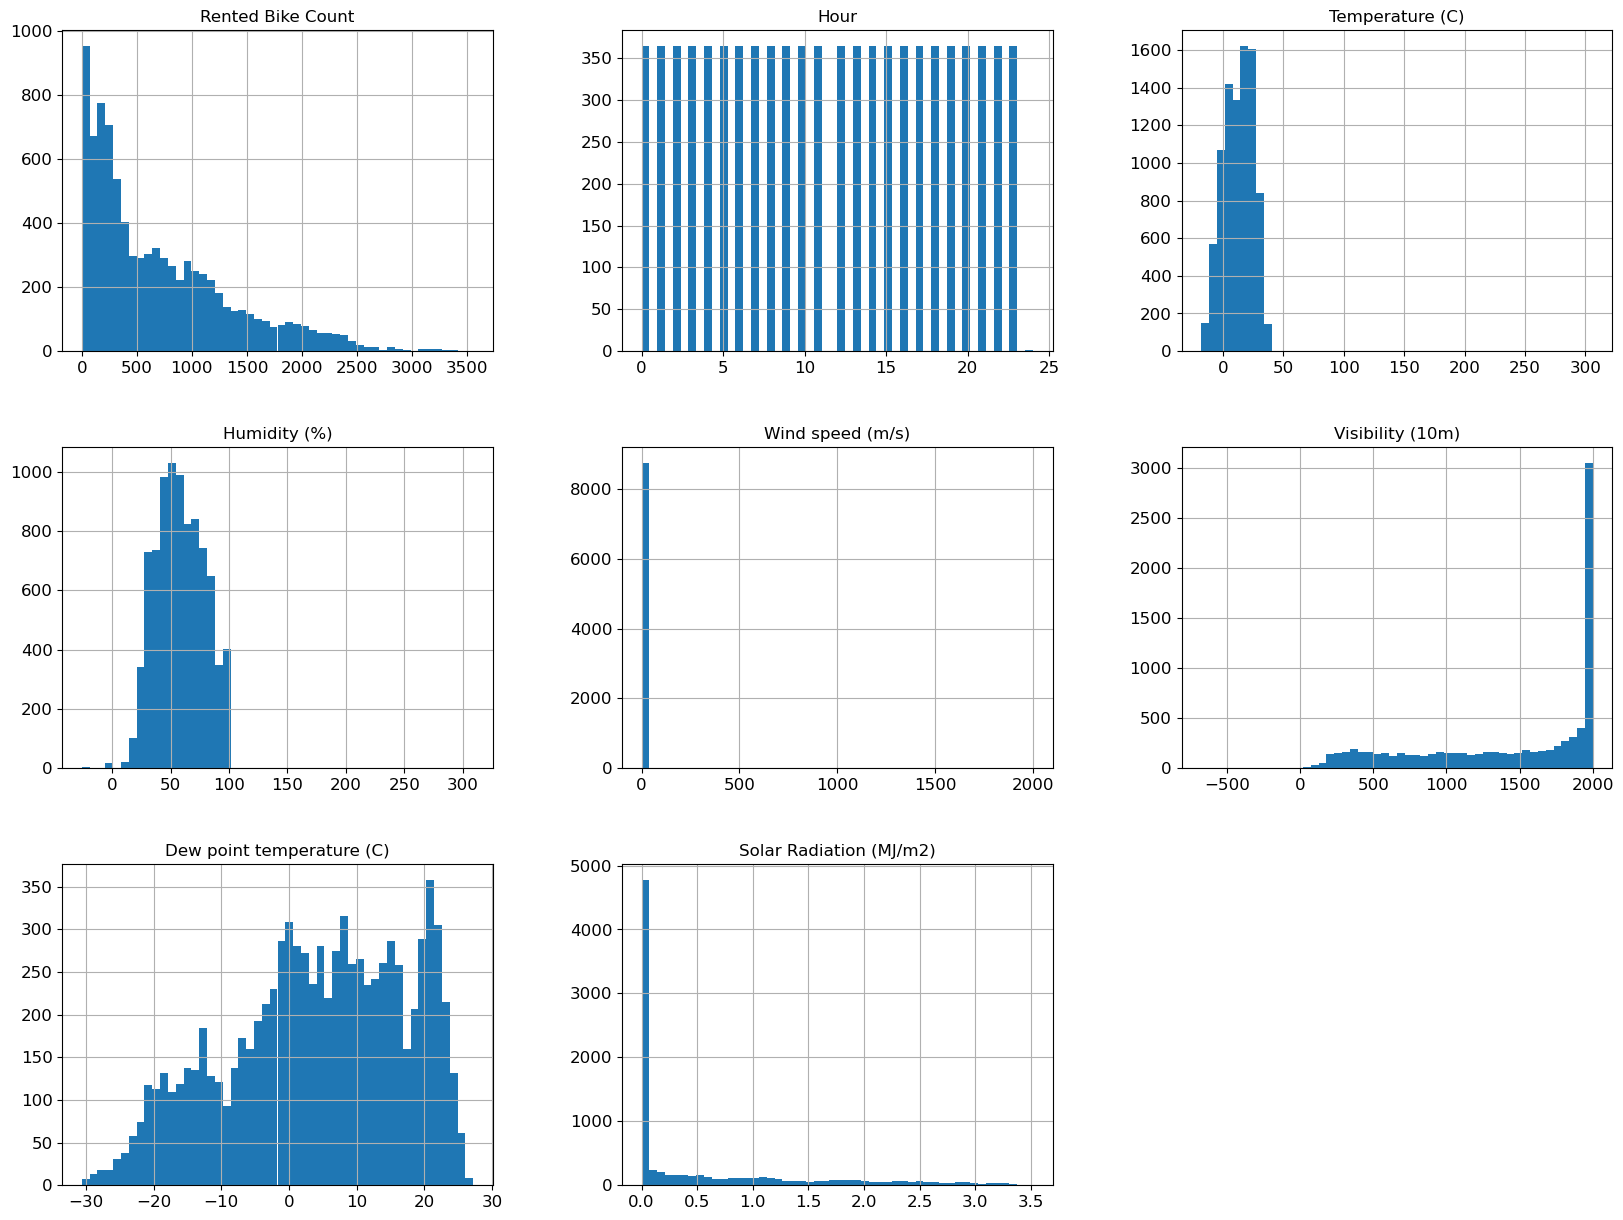

In [7]:
data.hist(bins=50, figsize=(20,15))
plt.show()
# Note: It appears that bike rentals are closed around lunch time (Hour histogram). 
# Also note that some of the histograms are tail-heavy and may need to be transformed at a later stage (Géron 51), especially if there are outliers or anomalies,
# which will be explored further.

grader.check("step01")

grader.check("step02")

**STEP03:** The "Functioning Day" feature records whether the bike rental was open for business on that day. For this assignment we are only interested in predicting demand on days when the business is open, so remove rows from the DataFrame where the business is closed. After doing this, delete the Functioning Day feature from the DataFrame and verify that this worked. **While you might solve this question in one way, be aware that there are multiple methods to achieve the same result in pandas, and these methods might be the subject of a question in the PracQuiz1 about this assignment.**

_Points:_ 3

In [8]:
# Ensure the rows where the business was closed are removed
data = data[data["Functioning Day"] == "Yes"] ## This creates a new DataFrame but doesn't save it

# Drop the 'Functioning Day' column
data = data.drop(columns=["Functioning Day"])

# Verify that the column is removed
print(data.info())

# Verify no rows remain where 'Rented Bike Count' is 0 (if required by the test case)
print(data[data["Rented Bike Count"] == 0])
# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step3_data = data.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8465 non-null   object 
 1   Rented Bike Count          8465 non-null   int64  
 2   Hour                       8465 non-null   int64  
 3   Temperature (C)            8465 non-null   float64
 4   Humidity (%)               8465 non-null   int64  
 5   Wind speed (m/s)           8464 non-null   float64
 6   Visibility (10m)           8465 non-null   int64  
 7   Dew point temperature (C)  8464 non-null   float64
 8   Solar Radiation (MJ/m2)    8465 non-null   float64
 9   Rainfall(mm)               8463 non-null   object 
 10  Snowfall (cm)              8465 non-null   object 
 11  Seasons                    8465 non-null   object 
 12  Holiday                    8465 non-null   object 
dtypes: float64(4), int64(4), object(5)
memory usage:

grader.check("step03")

**STEP04:** 
The goal is to predict bike rental demand using historical data. To achieve this, you will use regression techniques with "Bike Rental Count" as the target feature for this prediction, *but for this*, it is important that all other features in the data are numerical. Two of the features in the data, "Holiday" and "Season", need to be converted to numerical format. Write code to convert the "Holiday" feature to 0 or 1 from its current format. For the "Season" feature, add 4 new columns, labeled as "Winter", "Spring", "Summer", and "Autumn" then remove the "Season" column. Each of these columns should store a 0 or 1, depending on the corresponding season in each row. **While you might solve this question in one way, be aware that there are multiple methods to achieve the same result in pandas, and these methods might be the subject of a question in the PracQuiz1 about this assignment.**

_Points:_ 3

In [9]:
#converting Holiday column values into 0 (No Holiday) or 1(Holiday)

data['Holiday'] = data['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
#verify the conversion
data.head()

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0,0,Winter,0
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0,0,Winter,0
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0,0,Winter,0
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0,0,Winter,0
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0,0,Winter,0


In [10]:
#following the convention as set out in Geron (66-68)
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
seasons = encoder.fit_transform(data[['Seasons']]).toarray()

#discovered the need to reset the index after debugging post joining the new columns
data.reset_index(drop=True, inplace=True)

seasons=pd.DataFrame(seasons, columns=encoder.categories_[0]).astype(int)
data = data.join(seasons)

#deleting the season feature
data=data.drop(['Seasons'], axis=1)

#verifying that new columns were added with binary classification and that old Season feature has been dropped
data.head()
# The following code is used by the autograder, don't change it
step4_data = data.copy()

grader.check("step04")

**STEP05**: It is known that bike rentals depend strongly on whether it's a weekday or a weekend. Replace the Date feature with a Weekday feature that stores 0 or 1 depending on whether the date represents a weekend or weekday. **While you might solve this question in one way, be aware that there are multiple methods to achieve the same result in pandas, and these methods might be the subject of a question in the PracQuiz1 about this assignment.**

_Points:_ 3

In [11]:
import pandas as pd
import datetime

# Ensure 'Date' exists before applying the function
if 'Date' in data.columns:
    def date_is_weekday(datestring):
        # Return 0 if weekend, 1 if weekday
        dsplit = datestring.split('/')
        wday = datetime.datetime(int(dsplit[2]), int(dsplit[1]), int(dsplit[0])).weekday()
        return int(wday <= 4)

    # Apply the function safely
    data['Weekday'] = data['Date'].apply(date_is_weekday)

    # Drop the 'Date' column
    data.drop(columns=['Date'], inplace=True)

else:
    print("Error: 'Date' column not found. Check if it was removed earlier.")

# Verify transformation
print(data.head())
# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step5_data
step5_data = data.copy()

   Rented Bike Count  Hour  Temperature (C)  Humidity (%)  Wind speed (m/s)  \
0                254     0             -5.2            37               2.2   
1                204     1             -5.5            38               0.8   
2                173     2             -6.0            39               1.0   
3                107     3             -6.2            40               0.9   
4                 78     4             -6.0            36               2.3   

   Visibility (10m)  Dew point temperature (C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

  Rainfall(mm) Snowfall (cm)  Holiday  Autumn  Spring  Summer  Winter  Wee

grader.check("step05")

**STEP06** Convert all the remaining data to numerical format, with any non-numerical entries set to NaN.

_Points:_ 3

In [12]:
#i used apply to apply the to_numeric function across all features 
data = data.apply(pd.to_numeric, errors="coerce")

#verify all data types are numerical 
data.info()
# The following code is used by the autograder
# make sure your variable that contains that DataFrame from this step is the one assigned to step6_data
step6_data = data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8465 non-null   int64  
 1   Hour                       8465 non-null   int64  
 2   Temperature (C)            8465 non-null   float64
 3   Humidity (%)               8465 non-null   int64  
 4   Wind speed (m/s)           8464 non-null   float64
 5   Visibility (10m)           8465 non-null   int64  
 6   Dew point temperature (C)  8464 non-null   float64
 7   Solar Radiation (MJ/m2)    8465 non-null   float64
 8   Rainfall(mm)               8440 non-null   float64
 9   Snowfall (cm)              8442 non-null   float64
 10  Holiday                    8465 non-null   int64  
 11  Autumn                     8465 non-null   int32  
 12  Spring                     8465 non-null   int32  
 13  Summer                     8465 non-null   int32

grader.check("step06")

**STEP07** Examin the data and identify problematic entries. Set any problematic values in the numerical data to `np.nan` and check that this has worked. Once this is done, specify a **sklearn *pipeline* that will perform imputation** to replace problematic entries (nan values) with an appropriate **median** value ***and* any other pre-processing** that you think should be used. Just specify the pipeline - do ***not*** run it now.

_Points:_ 3

In [13]:
# Verifying presence of NaN values
print(data.isna().sum())

Rented Bike Count             0
Hour                          0
Temperature (C)               0
Humidity (%)                  0
Wind speed (m/s)              1
Visibility (10m)              0
Dew point temperature (C)     1
Solar Radiation (MJ/m2)       0
Rainfall(mm)                 25
Snowfall (cm)                23
Holiday                       0
Autumn                        0
Spring                        0
Summer                        0
Winter                        0
Weekday                       0
dtype: int64


grader.check("step07")

In [14]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Step 1: Replace problematic values with np.nan
data_cleaned = data.copy()

data_cleaned.loc[data_cleaned['Temperature (C)'] > 50, 'Temperature (C)'] = np.nan
data_cleaned.loc[(data_cleaned['Humidity (%)'] < 0) | (data_cleaned['Humidity (%)'] > 100), 'Humidity (%)'] = np.nan
data_cleaned.loc[data_cleaned['Wind speed (m/s)'] > 50, 'Wind speed (m/s)'] = np.nan
data_cleaned.loc[data_cleaned['Visibility (10m)'] < 0, 'Visibility (10m)'] = np.nan

# Step 2: Define the preprocessing pipeline
pipeline_step7 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Impute missing values with median
    ("scaler", StandardScaler())  # Scale the numerical features
])

# Step 3: Store cleaned data and pipeline in step7_data
step7_data = [data_cleaned, pipeline_step7]

**STEP08:** Generate a pre-processed version of the entire dataset by applying the pipeline defined in STEP07. Then, calculate the correlation of each feature with the target using either the pandas function corr() or numpy corrcoef() and find the 3 attributes that are the most correlated with bike rentals. 

_Points:_ 3

In [15]:
preprocessed_data = pipeline_step7.fit_transform(data)

In [16]:
# Define the correct column names (ensure they match your dataset structure)
columns = ["Rented Bike Count", "Hour", "Temperature (C)", "Humidity (%)", "Wind speed (m/s)",
           "Visibility (10m)", "Dew Point temperature (C)", "Solar Radiation (MJ/m2)", 
           "Rainfall(mm)", "Snowfall (cm)", "Holiday", "Autumn", "Spring", "Summer", "Winter", "Weekday"]


# Convert the processed data back into a DataFrame
preprocessed_data_df = pd.DataFrame(preprocessed_data, columns=columns)

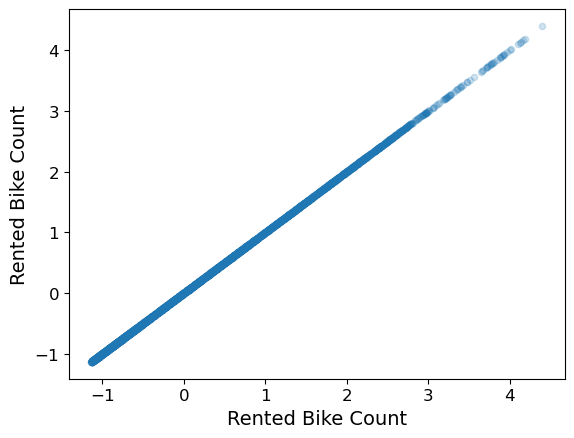

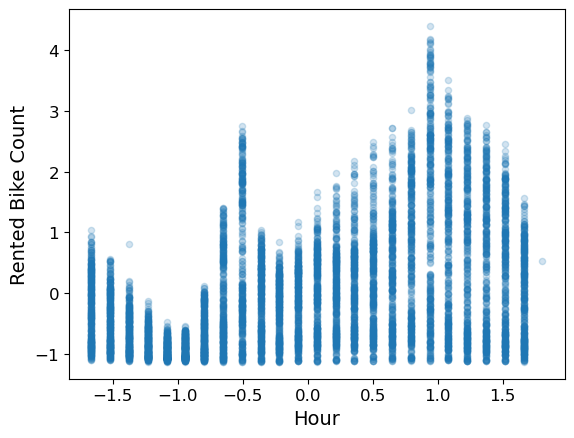

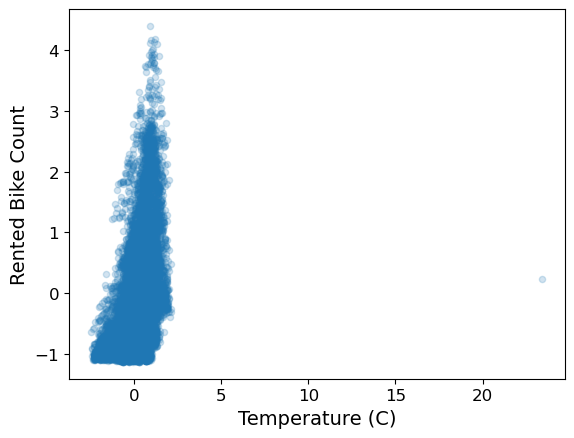

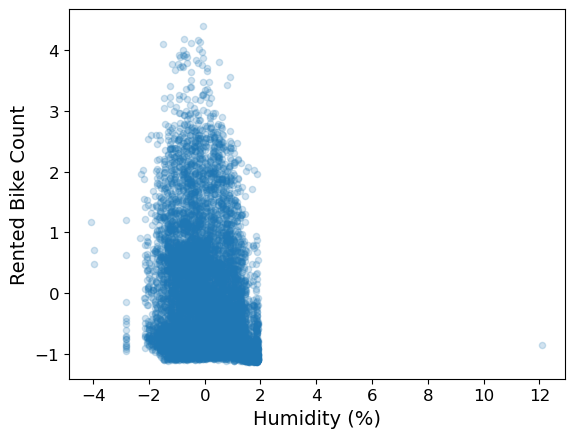

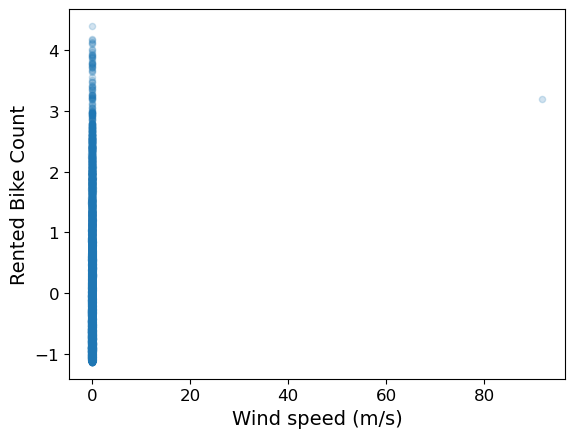

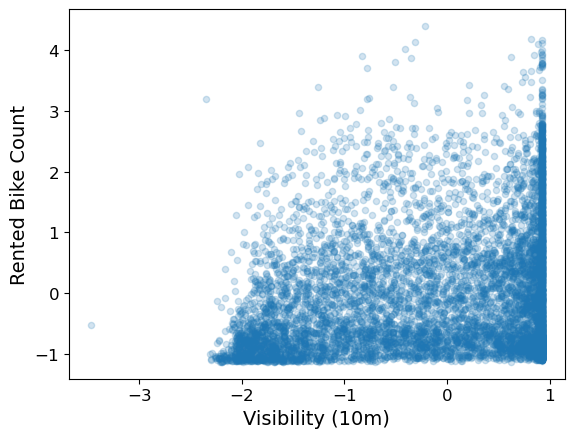

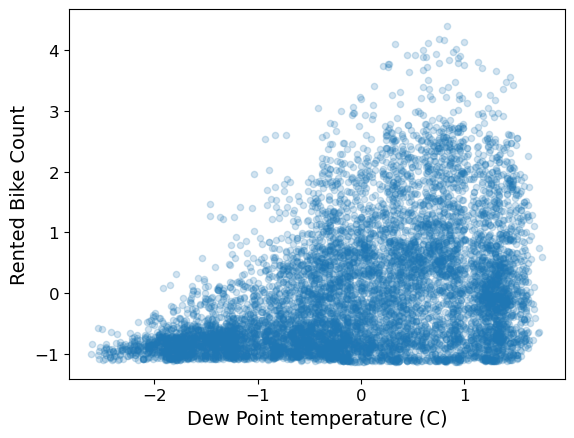

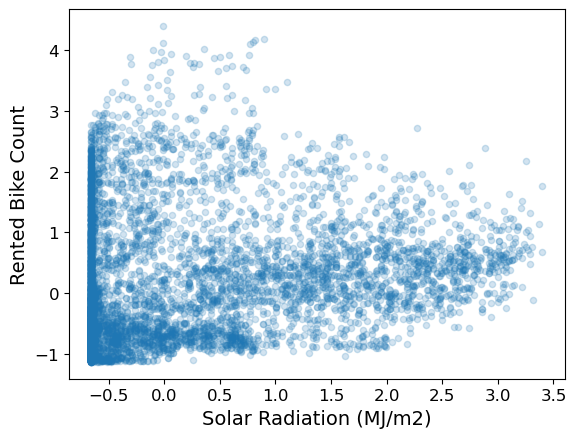

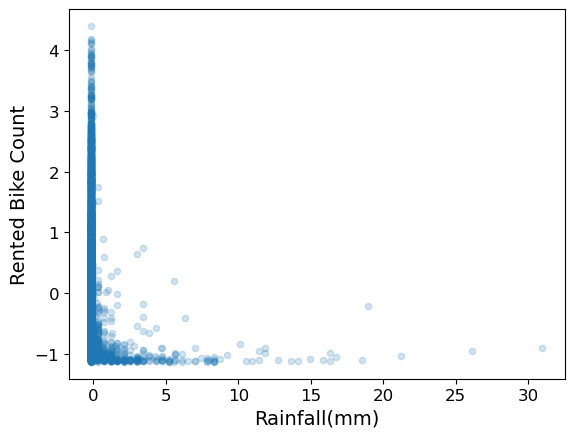

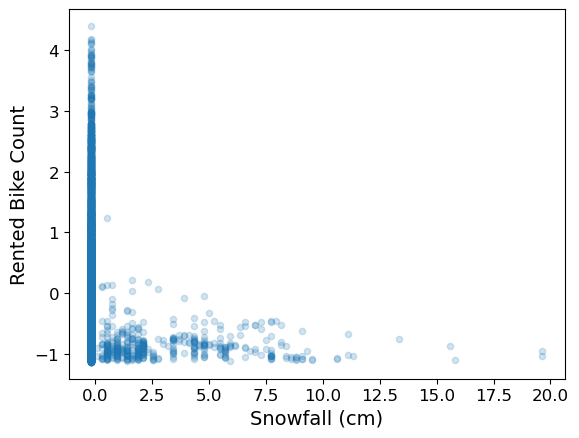

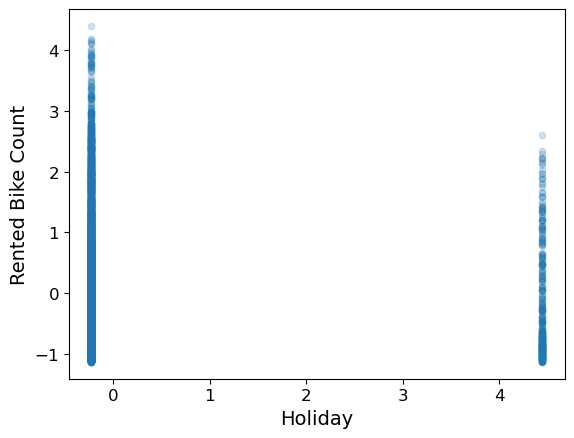

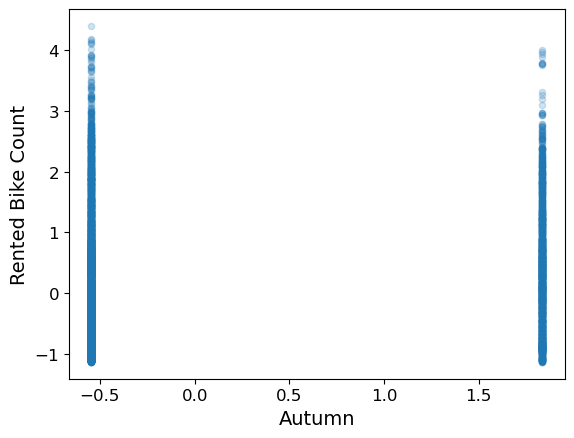

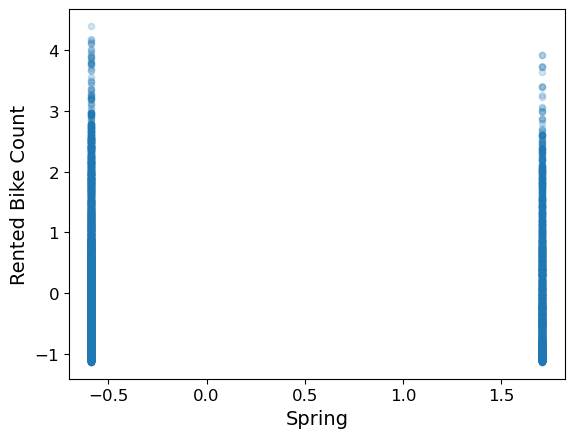

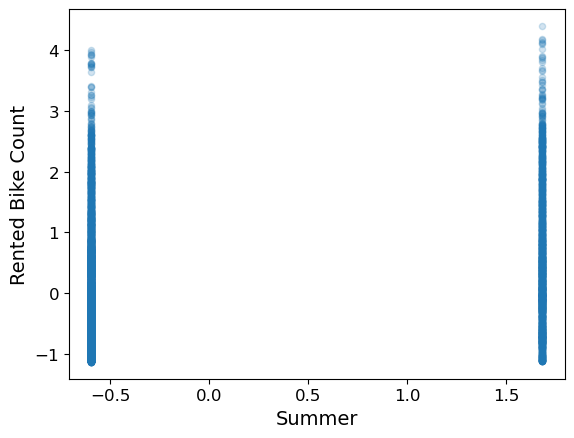

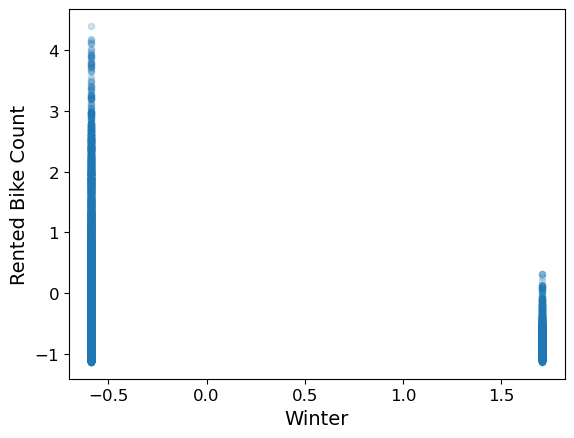

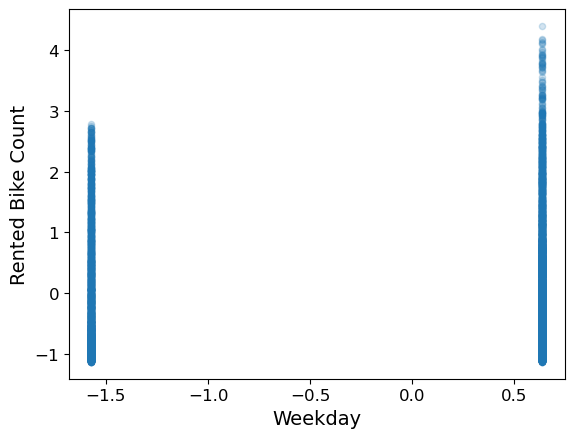

In [17]:
### Your code here

# (1) Scatter Plot for each feature vs. the target variable (Rented Bike Count)

for column in preprocessed_data_df.columns:
    preprocessed_data_df.plot(kind="scatter", x=column, y="Rented Bike Count", alpha=0.2)

In [18]:
corr_matrix = preprocessed_data_df.corr()

# top_3 should be an array of 3 strings ['attribute name', 'attribute name','attribute name']
top_3 = corr_matrix["Rented Bike Count"].drop("Rented Bike Count").abs().sort_values(ascending=False).head(3).index.tolist()

print(top_3)
# The following code is used by the autograder
# make sure your variable that contains a list of the names of the top 3 attributes is assigned to step3_data
step8_data = top_3.copy()

['Temperature (C)', 'Winter', 'Hour']


grader.check("step08")

**STEP09:** Divide the data into training and test sets using where 20% of the data is kept for testing. Create a pipeline that includes the linear regression model in addition to the pipeline defined in STEP07. Fit the pipeline to the training set and calculate the `rmse` of the fit to evaluate its performance. As a comparison, compute the `rmse` that would be obtained by predicting the mean value of bike rentals for all training examples.

_Points:_ 3

In [19]:
# you can use make_pipline to create a new pipiline by adding a model at the end of pipeline_step7 or you can simply create a new pipeline. 
# whatever you end up doing, make sure it is called pipeline_step9
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# split the data (20% as test size)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

#step 1:  separating Rented Bike Count as this is the value to predict

y_train = train_set["Rented Bike Count"].copy()
X_train = train_set.drop(["Rented Bike Count"], axis=1)

y_test = test_set["Rented Bike Count"].copy()
X_test = test_set.drop(["Rented Bike Count"], axis=1)

#step 2: create a new pipeline with linear regression 
pipeline_step9 = make_pipeline(
    pipeline_step7,  # Reuse preprocessing pipeline from STEP07
    LinearRegression()
)

#step 3: train the model 
pipeline_step9.fit(X_train, y_train)

#step 4 calculate the RMSE of the fit to the training data
y_train_pred = pipeline_step9.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

#Step 5:calculate the RMSE of the baseline model (by predicting the mean value of bike rentals for all training examples)
baseline_pred = np.full(y_train.shape, y_train.mean())
rmse_baseline = np.sqrt(mean_squared_error(y_train, baseline_pred))


print("RMSE for training data:", rmse_train)
print("RMSE for baseline (predicting mean):", rmse_baseline)

# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step9_data = [rmse_train,rmse_baseline]

RMSE for training data: 439.82296569998164
RMSE for baseline (predicting mean): 646.170499547999


In [20]:
# Experimenting with adding the polynomial feature
# Note: I did experiment with adding the polynomial feature to subsequent models, e.g., SVR, but the performance was worse in most cases.

from sklearn.preprocessing import PolynomialFeatures

degree = 2

pipeline_step9_poly = make_pipeline(
    pipeline_step7,  # Reuse preprocessing pipeline from STEP07
    PolynomialFeatures(degree),  # Generate polynomial features
    LinearRegression()  # Apply regression model
)

pipeline_step9_poly.fit(X_train, y_train)
y_pred_pipeline_step9_poly = pipeline_step9_poly.predict(X_train)

rmse_lr_poly = np.sqrt(mean_squared_error(y_pred_pipeline_step9_poly,y_train))
print(f'LR RMSE Model (All w/ polynomial): {rmse_lr_poly}')

baseline = np.full(y_train.shape, y_train.mean())
rmse_bl = np.sqrt(mean_squared_error(y_train, baseline,squared=False))
print(f'RMSE Baseline: {rmse_bl}')

LR RMSE Model (All w/ polynomial): 346.5534193078439
RMSE Baseline: 25.419883940490347


Text(0, 0.5, 'Predicted')

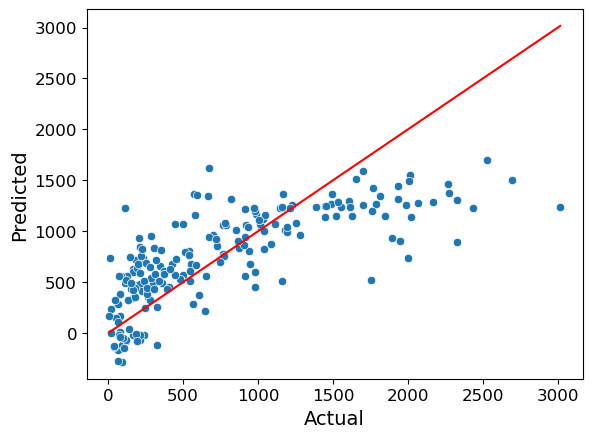

In [21]:
#The following code will show a visualisation of the fit for your linear regression.
# I will use your pipeline_step9 to predict on 200 points from the training data
subset_size = 200
y_train_pred = pipeline_step9.predict(X_train[:subset_size])

# Then I create a scatterplot of predicted vs actual values using your variables from the cell above
ax = sns.scatterplot(x=y_train[:subset_size], y=y_train_pred)
# A perfect solution would look like the red line
sns.lineplot(x=y_train[:subset_size], y=y_train[:subset_size], color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

grader.check("step09")

**STEP10:**  Fit a Kernel Ridge regression model (imported from sklearn.kernel_ridge) to the X_train data from STEP09. Build a new pipeline that includes the Kernel Ridge regression model in addition to the pipeline defined in STEP07, and fit it to the training data using default settings. Generate a scatter plot of the predicted values against the actual values for the training data, and calculate the RMSE of the fit to the training data.

_Points:_ 3

In [22]:
from sklearn.kernel_ridge import KernelRidge

# you can use make_pipline to create a new pipiline by adding a model at the end of pipeline_step7 or you can simply create a new pipeline. 
# whatever you end up doing, make sure it is called pipeline_step10
#step1: create a new pipeline with kernel ridge regression
pipeline_step10 = make_pipeline(
    pipeline_step7, #reuse reprocessing pipeline from step07
    KernelRidge(kernel="linear", alpha=0.1) #use linear kernel and lower alpha
)

#step 2: train the model
pipeline_step10.fit(X_train, y_train)

# step 3: make predictions on the training data
y_pred_train_KR = pipeline_step10.predict(X_train)

# calculate rmse for training data
rmse_train_KR =  np.sqrt(mean_squared_error(y_train, y_pred_train_KR))
print('Kernel Ridge model RMSE on training data:', rmse_train_KR)
print(f'RMSE Baseline: {rmse_bl}')
# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step10_data = [rmse_train_KR,pipeline_step10]

Kernel Ridge model RMSE on training data: 853.4495911289363
RMSE Baseline: 25.419883940490347


Text(0, 0.5, 'Predicted')

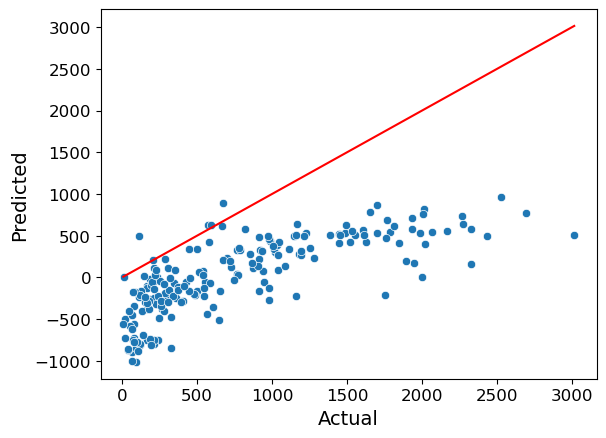

In [23]:
# I will use your pipeline_step10 to predict on 200 points from the training data
subset_size = 200
y_train_pred = pipeline_step10.predict(X_train[:subset_size])

# Then create a scatterplot of predicted vs actual values using your variables from the cell above
ax = sns.scatterplot(x=y_train[:subset_size], y=y_train_pred)
sns.lineplot(x=y_train[:subset_size], y=y_train[:subset_size], color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

grader.check("step10")

**STEP11:** Fit a Support Vector Regression (from sklearn.svm import SVR). As you did for STEP10, create a new pipeline using the pipelinr from STEP07 and this model and fit it to your training data, using the default settings. Again, calculate the RMSE of the fit to the training data.

_Points:_ 4

In [24]:
from sklearn.svm import SVR

# you can use make_pipline to create a new pipiline by adding a model at the end of pipeline_step7 or you can simply create a new pipeline. 
# whatever you end up doing, make sure it is called pipeline_step11
#step1:create a new pipeline with SVM
pipeline_step11 = make_pipeline(
    pipeline_step7,#reuse preprocessing pipeline from STEP07
    SVR(kernel="linear", C=10, epsilon=0.1))#improved parameters

#step2: train the model
pipeline_step11.fit(X_train, y_train)
#step 3:make predictions on the training data
y_pred_train_SVR = pipeline_step11.predict(X_train)


#step4: calculate rmse for training data
rmse_train_SVR =  np.sqrt(mean_squared_error(y_pred_train_SVR,y_train))

print('Support Vector Regression model RMSE on training data:', rmse_train_SVR)
print(f'---for reference---')
print(f'RMSE Baseline: {rmse_bl}')

# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step11_data = [rmse_train_SVR,pipeline_step11]

Support Vector Regression model RMSE on training data: 453.82122302169705
---for reference---
RMSE Baseline: 25.419883940490347


Text(0, 0.5, 'Predicted')

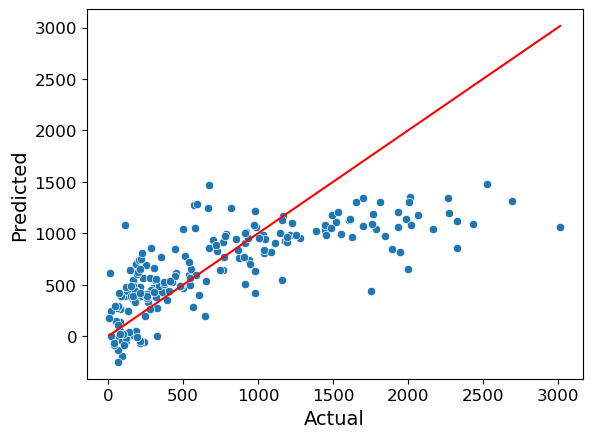

In [25]:
# use your pipeline_step10 to predict on 200 points from the training data
subset_size = 200
y_train_pred = pipeline_step11.predict(X_train[:subset_size])

# Then create a scatterplot of predicted vs actual values using your variables from the cell above
ax = sns.scatterplot(x=y_train[:subset_size], y=y_train_pred)
sns.lineplot(x=y_train[:subset_size], y=y_train[:subset_size], color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

grader.check("step11")

**STEP12:** Perform a 10 fold cross validation for each of the three model (LinearRegression,KernelRidge,SVR). This splits the training set (that we've used above) into 10 equal size subsets, and uses each in turn as the validation set while training a model with the other 9. You should therefore have 10 rmse values for each cross validation run. Find the mean and standard deviation of the rmse values obtained for each model for the validation splits.

_Points:_ 5

In [26]:
# you might need some or all of the following imports
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# Step 1: Define cross-validation strategy (10 folds)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Step 2: Define models with the pipeline
pipeline_LR = make_pipeline(pipeline_step7, LinearRegression())
pipeline_KR = make_pipeline(pipeline_step7, KernelRidge(kernel="linear", alpha=0.1))
pipeline_SVR = make_pipeline(pipeline_step7, SVR(kernel="linear", C=10, epsilon=0.1))

# Step 3: Compute cross-validated RMSE for each model
cv_LR_scores = np.sqrt(-cross_val_score(pipeline_LR, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
cv_KR_scores = np.sqrt(-cross_val_score(pipeline_KR, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
cv_SVR_scores = np.sqrt(-cross_val_score(pipeline_SVR, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))

# Print the individual RMSE values for each fold
print("Linear Regression RMSE values for each fold:")
print(cv_LR_scores)
print("\nKernel Ridge RMSE values for each fold:")
print(cv_KR_scores)
print("\nSupport Vector Regression RMSE values for each fold:")
print(cv_SVR_scores)

#Linear Regression CV mean and std RMSE from the 10 folds:
rmse_LR_mean, rmse_LR_std = np.mean(cv_LR_scores), np.std(cv_LR_scores)
print('Linear Regression CV Scores:') 
print(f'Mean: {rmse_LR_mean:.2f}, Std: {rmse_LR_std:.2f}\n')


#Linear Regression CV mean and std:
rmse_KR_mean, rmse_KR_std = np.mean(cv_KR_scores), np.std(cv_KR_scores)
print('Kernel Ridge Regression CV Scores:') 
print(f'Mean: {rmse_KR_mean:.2f}, Std: {rmse_KR_std:.2f}\n')


#Linear Regression CV mean and std:
rmse_SVR_mean, rmse_SVR_std = np.mean(cv_SVR_scores), np.std(cv_SVR_scores)

print('Support Vector Regression CV Scores:') 
print(f'Mean: {rmse_SVR_mean:.2f}, Std: {rmse_SVR_std:.2f}\n')


# The following code is used by the autograder
step12_data = [rmse_LR_mean,rmse_KR_mean,rmse_SVR_mean]

Linear Regression RMSE values for each fold:
[ 429.03122682  445.80048902  424.11566529 1266.18207008  433.44821571
  457.12537636  464.50029468  558.95320078  439.78739041  439.11305712]

Kernel Ridge RMSE values for each fold:
[ 848.65712717  855.40818585  836.71877783 1431.30482959  845.94782459
  855.33452221  887.67536559  919.52234453  860.20088161  850.79076003]

Support Vector Regression RMSE values for each fold:
[442.79710317 459.67918145 429.26879482 793.9543888  427.15862155
 473.15353369 486.37519444 491.24443064 457.65306077 452.50078091]
Linear Regression CV Scores:
Mean: 535.81, Std: 246.23

Kernel Ridge Regression CV Scores:
Mean: 919.16, Std: 172.25

Support Vector Regression CV Scores:
Mean: 491.38, Std: 102.91



grader.check("step12")

**STEP13:** Both the Kernel Ridge Regression and Support Vector Regression have hyperparameters that can be adjusted to suit the problem. Use grid search to systematically compare the generalisation performance (rmse) obtained with different hyperparameter settings (still with 10-fold CV). Use the sklearn function GridSearchCV to do this.

For KernelRidge, vary the hyperparameter alpha. (note, if you are using KernelRidge as the last step in a pipeline, alpha is refered to as kernelridge__alpha) 

For SVR, vary the hyperparameter C. (note, if you are using SVR as the last step in a pipeline, C is refered to as SVR__C)

Find the hyperparameter setting for each medel.

Finally, train and apply both models, with the best hyperparameter settings, to the test set and report the performance as rmse.

_Points:_ 5

In [ ]:
from sklearn.model_selection import GridSearchCV


# Define the pipeline for SVR and Kernel Ridge Regression (KRR)
svr_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),  # Handle missing values
    StandardScaler(),
    SVR()
)

kr_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),  # Handle missing values
    StandardScaler(),
    KernelRidge()
)

# Define the GridSearchCV objects for each model

# For Kernel Ridge Regression, vary the 'alpha' hyperparameter
kr_param_grid = {'kernelridge__alpha': [0.1, 1, 10, 100, 1000]}

# Define the GridSearchCV objects for each model
kr_cv = GridSearchCV(kr_pipeline, kr_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)

# For Support Vector Regression, vary the 'C' hyperparameter
svr_param_grid = {'svr__C': [0.1, 1, 10, 100, 1000, 5000, 10000]}

svr_cv =GridSearchCV(svr_pipeline, svr_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)

# Fit the GridSearchCV objects to the training data
kr_cv.fit(X_train, y_train)
svr_cv.fit(X_train, y_train)

# Print the best hyperparameter setting for each model
print("Best hyperparameter setting for Kernel Ridge Regression:", kr_cv.best_params_)
print("Best hyperparameter setting for Support Vector Regression:", svr_cv.best_params_)

# Create pipeline using the best hyperparameter
pipeline_best_kr = kr_cv.best_estimator_
pipeline_best_svr = svr_cv.best_estimator_

# Train and apply the chosen model to the test set
kr_predictions = pipeline_best_kr.predict(X_test)
kr_rmse = np.sqrt(mean_squared_error(y_test, kr_predictions))

svr_predictions = pipeline_best_svr.predict(X_test)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_predictions))

print("Kernel Ridge Regression RMSE on test set:", kr_rmse)
print("Support Vector Regression RMSE on test set:", svr_rmse)

# The following code is used by the autograder
# make sure your variable that contains that data from this step is the one assigned to step3_data
step13_data = [kr_rmse , svr_rmse, kr_cv , svr_cv,pipeline_best_kr,pipeline_best_svr]

In [29]:
# use your pipeline_best_svr to predict on 200 points from the training data
subset_size = 200
y_train_pred = pipeline_best_svr.predict(X_train[:subset_size])

# Then create a scatterplot of predicted vs actual values using your variables from the cell above
ax = sns.scatterplot(x=y_train[:subset_size], y=y_train_pred)
sns.lineplot(x=y_train[:subset_size], y=y_train[:subset_size], color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

NameError: name 'pipeline_best_svr' is not defined

grader.check("step13")